In [1]:
!pip install timm

     |████████████████████████████████| 376 kB 925 kB/s eta 0:00:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import timm

import gc
import os
import time
import random
from datetime import datetime
import shutil

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from shutil import copyfile

In [3]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(111)

In [4]:
# general global variables
DATA_PATH = "/kaggle/input/pollen-dataset/Pollen_data"
IMAGES_PATH = os.path.join(DATA_PATH, "images")

In [5]:
df = pd.read_csv(os.path.join(DATA_PATH, "data.csv"))
df.head()

,image_id,label
0,20190404111949_OBJ_0_1080_876.png,0
1,20190404110111_OBJ_27_393_106.png,0
2,20190404114349_OBJ_24_349_190.png,0
3,20190404112959_OBJ_33_841_184.png,0
4,20190404110146_OBJ_3_444_825.png,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11279 entries, 0 to 11278
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  11279 non-null  object
 1   label     11279 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.4+ KB


<AxesSubplot:>

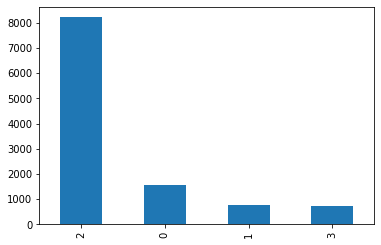

In [7]:
df.label.value_counts().plot(kind="bar")

In [8]:
# Here for splitting the data into train, test and validation. We will using train_test_split from sklearn

# First divide the data into train data (80%) and remaining data(20%)
# Second divide the remaining data into validation (10%) and test data(10%)
train_df, remaining_df = model_selection.train_test_split(df, test_size=0.2, random_state=42, stratify=df.label.values)

Text(0.5, 1.0, 'Training data distribution')

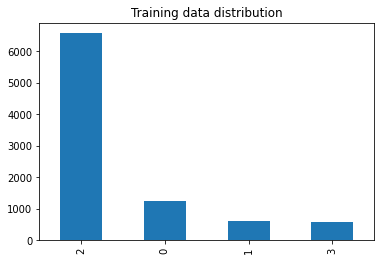

In [9]:
# Training data distribution
train_df.label.value_counts().plot(kind="bar")
plt.title("Training data distribution")

In [10]:
train_df.label.value_counts()

2    6573
0    1253
1     618
3     579
Name: label, dtype: int64

Text(0.5, 1.0, 'Except training data distribution')

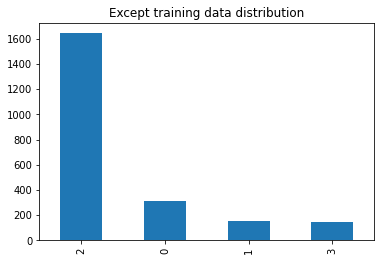

In [11]:
remaining_df.label.value_counts().plot(kind="bar")
plt.title("Except training data distribution")

In [12]:
# Dividing remaining data into validation and test set
valid_df, test_df = model_selection.train_test_split(remaining_df, test_size=0.5, random_state=42, stratify=remaining_df.label.values)

In [13]:
valid_df.label.value_counts()

2    821
0    156
1     78
3     73
Name: label, dtype: int64

Text(0.5, 1.0, 'Validation data distribution')

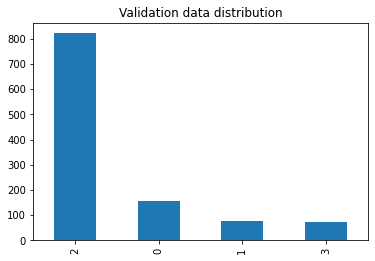

In [14]:
valid_df.label.value_counts().plot(kind="bar")
plt.title("Validation data distribution")

Text(0.5, 1.0, 'Test data distribution')

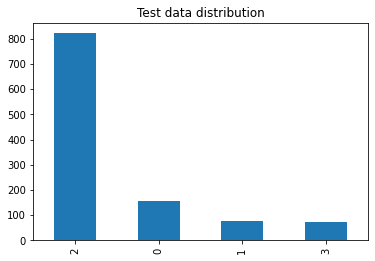

In [15]:
test_df.label.value_counts().plot(kind="bar")
plt.title("Test data distribution")

In [16]:
from torch.utils.data import DataLoader
class PollenDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """

    def __init__(self, df, data_path=DATA_PATH, transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.data_dir = "images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        label = np.asarray(label, dtype='int64')

        if self.transforms is not None:
            image = self.transforms(img)

        return image, torch.from_numpy(label)

In [17]:
IMG_SIZE = 224
BATCH_SIZE = 16

In [18]:
# create image augmentations

transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [19]:
# Train and validation dataset with transformations
train_dataset = PollenDataset(train_df, transforms=transforms_train)
valid_dataset = PollenDataset(valid_df, transforms=transforms_valid)

In [20]:
# Train and validation loader 
train_loader = DataLoader(
     dataset=train_dataset,
     batch_size=BATCH_SIZE,
     shuffle = True
     )
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
    )

In [21]:
train_sample = iter(train_loader)
data, label = train_sample.next()
print(data.shape)
print(data.max())
print(data.min())

torch.Size([16, 3, 224, 224])
tensor(2.1975)
tensor(-2.1179)


In [22]:
data.dtype

torch.float32

In [23]:
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_384',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch32_224_in21k',
 'vit_large_patch32_384',
 'vit_large_r50_s32_224',
 'vit_large_r50_s32_224_in21k',
 'vit_large_r50_s32_384',
 'vit_small_patch16_224',
 'vit_small_patch16_224_in21k',
 'vit_small_patch16_384',
 'vit_small_patch32_224',
 'vit_small_patch32_224_in21k',
 'vit_small_patch32_384',
 'vit_small_r26_s32_224',
 'vit_small_r26_s32_224_in21k',
 'vit_small_r26_s32_384',
 'vit_small_resnet2

### Will be using _patch16_224_ and _patch32_224_ vit models for training and testing

In [24]:
# VIT model with patch16
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained)
        self.model.head = nn.Linear(self.model.head.in_features, n_classes) # Classification head

    def forward(self, x):
        x = self.model(x)
        return x  

# VIT model with patch32
class ViTBase32(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase32, self).__init__()
        
        self.model = timm.create_model("vit_base_patch32_224", pretrained)
        self.model.head = nn.Linear(self.model.head.in_features, n_classes) # Classification head

    def forward(self, x):
        x = self.model(x)
        return x

In [25]:
model = ViTBase16(n_classes=4, pretrained=True)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [27]:
!pip install torchsummary

In [28]:
from torchsummary import summary
model = model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

In [29]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("total trainable parameters = {} Million".format(str(round(total_params/1000000))))

total trainable parameters = 86 Million


In [30]:
# Checking the model performance with out any training, on training set, so that we can 
# Conclude Later during that the model is atleast converging later on
baseline_train_loss = 0.0
baseline_train_accuracy = 0.0
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
    model.eval()
    for data, target in train_loader:
        data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
        output = model(data)
        loss = criterion(output, target)
        accuracy = (output.argmax(dim=1) == target).float().mean()
        baseline_train_loss += loss
        baseline_train_accuracy += accuracy

In [31]:
print("Total Training batches = {}".format(len(train_loader)))
print("Baseline Training Data Loss = {}".format(baseline_train_loss/len(train_loader)))
print("Baseline Training Data Accuracy = {} %".format(100*baseline_train_accuracy/len(train_loader)))

Total Training batches = 564
Baseline Training Data Loss = 1.258602499961853
Baseline Training Data Accuracy = 67.64922332763672 %


In [32]:
baseline_valid_loss = 0.0
baseline_valid_accuracy = 0.0
with torch.no_grad():
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
        output = model(data)
        loss = criterion(output, target)
        accuracy = (output.argmax(dim=1) == target).float().mean()
        baseline_valid_loss += loss
        baseline_valid_accuracy += accuracy

In [33]:
print("Total Validation batches = {}".format(len(valid_loader)))
print("Baseline Validation Data Loss = {}".format(baseline_valid_loss/len(valid_loader)))
print("Baseline Validation Data Accuracy = {} %".format(100*baseline_valid_accuracy/len(valid_loader)))

Total Validation batches = 71
Baseline Validation Data Loss = 1.3464611768722534
Baseline Validation Data Accuracy = 73.5035171508789 %


## Freezing all the layers

In [34]:
for param in model.parameters():
    param.requires_grad = False

In [35]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("total trainable parameters = {} Million".format(str(round(total_params/1000000))))

total trainable parameters = 0 Million


In [36]:
model.model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [37]:
def unfreeze_blocks(model, blocks=[11], do_unfreeze = False): # default unfreeze the 11th block only by default
    if do_unfreeze:
        for i in blocks:
            for param in model.model.blocks[i].parameters():
                param.requires_grad = True
    
    return model

In [38]:
model = unfreeze_blocks(model, [10, 11], True)

In [39]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("total trainable parameters = {} Million".format(str(round(total_params/1000000))))

total trainable parameters = 21 Million


In [40]:
def unfreeze_head(model):
    # Final MLP heads of the classifier, unfreezing
    for param in model.model.norm.parameters():
        param.requires_grad = True

    for param in model.model.pre_logits.parameters():
        param.requires_grad = True

    for param in model.model.head.parameters():
        param.requires_grad = True
    
    return model

In [41]:
model = unfreeze_head(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("total trainable parameters = {} ".format(str(round(total_params))))

total trainable parameters = 21268228 


#### Unfreezing the head added 4612 extra parameters

In [42]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        print("Saving the best model !")
        shutil.copyfile(filename, 'model_best.pth.tar')

In [43]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [44]:
# Initializations 
LR = 0.001
epochs = 10
check_every = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min', 
                              factor=0.75, 
                              patience=10, 
                              threshold=0.0001, 
                              threshold_mode='rel', 
                              cooldown=0, 
                              min_lr=0, 
                              eps=1e-08, 
                              verbose=True)
train_loss_array = []
train_acc_array = []
val_loss_array = []
val_acc_array = []
best_acc1 = 0

In [45]:
# Begin training
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    i = 0
    for counter, (data, target) in enumerate(train_loader):
        i += 1
        data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64) # load data to device
        
        # clear the gradients of all optimizable variables
        optimizer.zero_grad()
        # compute outputs by passing input to the model
        output = model(data)
        # the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Calculating accuracy
        accuracy = (output.argmax(dim=1) == target).float().mean()
    
        # update training loss and accuracy
        epoch_loss += loss
        epoch_accuracy += accuracy
        optimizer.step()
        
        if i % check_every == 0:
            # keep track of validation loss
            valid_loss = 0.0
            valid_accuracy = 0.0
            with torch.no_grad():
                model.eval()
                for data, target in valid_loader:
                    data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
                    output = model(data)
                    loss = criterion(output, target)
                    accuracy = (output.argmax(dim=1) == target).float().mean()
                    # update average validation loss and accuracy
                    valid_loss += loss
                    valid_accuracy += accuracy
            
            # Score transfer to CPU
            valid_loss_cpu = valid_loss.cpu().detach().numpy() 
            valid_accuracy_cpu = valid_accuracy.cpu().detach().numpy() 
            epoch_loss_cpu = epoch_loss.cpu().detach().numpy() 
            epoch_accuracy_cpu = epoch_accuracy.cpu().detach().numpy() 
            
            val_loss_array.append(valid_loss_cpu/len(valid_loader)) 
            val_acc_array.append(valid_accuracy_cpu/len(valid_loader))
            train_loss_array.append(epoch_loss_cpu/(counter+1)) 
            train_acc_array.append(epoch_accuracy_cpu/(counter+1))
            print("[{} epoch {} batch] Train Loss : {:.3f} \t Train Accuracy : {:.3f} \t Valid loss : {:.3f} \t Valid Accuracy : {:.3f}".format(epoch+1, 
                                                                                                                                                i, 
                                                                                                                                                epoch_loss_cpu/(counter+1), 
                                                                                                                                                epoch_accuracy_cpu/(counter+1), 
                                                                                                                                                valid_loss_cpu / len(valid_loader), 
                                                                                                                                                valid_accuracy_cpu / len(valid_loader)))
            val_loss = valid_loss/len(valid_loader) 
            acc1 = valid_accuracy/len(valid_loader)
            is_best = acc1 > best_acc1
            best_acc1 = max(acc1, best_acc1)
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_acc1': best_acc1,
                'optimizer' : optimizer.state_dict(),
            }, is_best)
            
            # Learning rate scheduler step
            scheduler.step(val_loss)
        model.train()
    
print("Finish Training!")

[1 epoch 100 batch] Train Loss : 1.323 	 Train Accuracy : 0.704 	 Valid loss : 0.522 	 Valid Accuracy : 0.844
Saving the best model !
[1 epoch 200 batch] Train Loss : 0.959 	 Train Accuracy : 0.760 	 Valid loss : 0.322 	 Valid Accuracy : 0.903
Saving the best model !
[1 epoch 300 batch] Train Loss : 0.792 	 Train Accuracy : 0.790 	 Valid loss : 0.360 	 Valid Accuracy : 0.892
[1 epoch 400 batch] Train Loss : 0.697 	 Train Accuracy : 0.809 	 Valid loss : 0.317 	 Valid Accuracy : 0.903
[1 epoch 500 batch] Train Loss : 0.642 	 Train Accuracy : 0.820 	 Valid loss : 0.426 	 Valid Accuracy : 0.894
[2 epoch 100 batch] Train Loss : 0.376 	 Train Accuracy : 0.876 	 Valid loss : 0.257 	 Valid Accuracy : 0.930
Saving the best model !
[2 epoch 200 batch] Train Loss : 0.375 	 Train Accuracy : 0.878 	 Valid loss : 0.254 	 Valid Accuracy : 0.931
Saving the best model !
[2 epoch 300 batch] Train Loss : 0.360 	 Train Accuracy : 0.882 	 Valid loss : 0.224 	 Valid Accuracy : 0.932
Saving the best model !


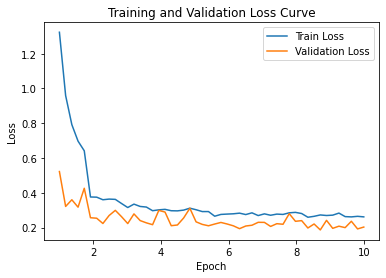

In [46]:
epoch_array = np.linspace(1, epochs, len(train_loss_array))
plt.plot(epoch_array, train_loss_array, label = "Train Loss")
plt.plot(epoch_array, val_loss_array, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

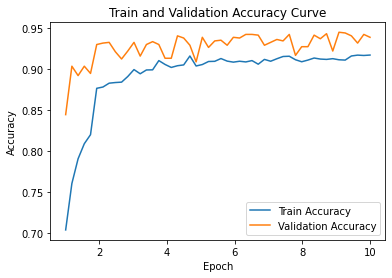

In [47]:
plt.plot(epoch_array, train_acc_array, label = "Train Accuracy")
plt.plot(epoch_array, val_acc_array, label = "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Curve')
plt.legend()
plt.show()

### Performance measure of best model

In [48]:
# Best validation accuracy Vit32_224 Model
PATH = 'model_best.pth.tar'
state = torch.load(PATH)

model = ViTBase16(n_classes=4, pretrained=False)
model.load_state_dict(state['state_dict'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))
model = model.to(device=device)

Using cuda


In [49]:
print("######### Generating confusion Matrix on Validation Set ########")
prediction = []
ground_truth = []
with torch.no_grad():
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
        output = model(data)
        prediction.extend(output.argmax(dim=1))
        ground_truth.extend(target)

######### Generating confusion Matrix on Validation Set ########


In [50]:
prediction_array = [int(i.cpu().detach().numpy()) for i in prediction]
ground_truth_array = [int(i.cpu().detach().numpy()) for i in ground_truth]

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(ground_truth_array, prediction_array))
print(confusion_matrix(ground_truth_array, prediction_array))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       156
           1       0.91      0.92      0.92        78
           2       0.94      0.99      0.97       821
           3       0.98      0.79      0.88        73

    accuracy                           0.94      1128
   macro avg       0.95      0.87      0.90      1128
weighted avg       0.94      0.94      0.94      1128

[[120   2  34   0]
 [  2  72   4   0]
 [  2   3 815   1]
 [  2   2  11  58]]


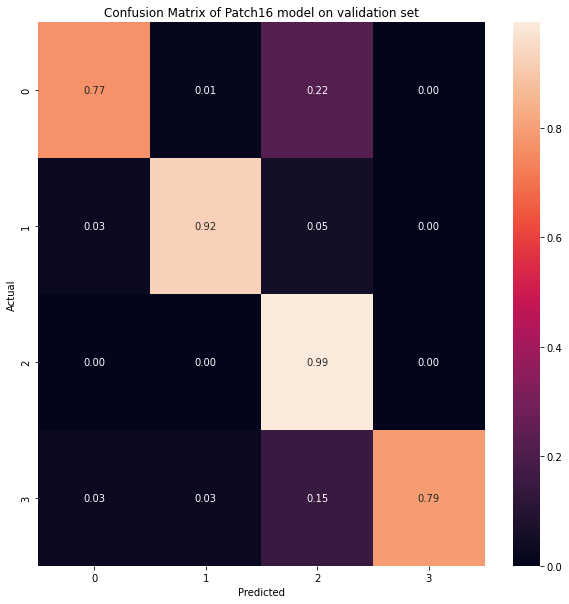

In [52]:
import seaborn as sns
cm = confusion_matrix(ground_truth_array, prediction_array)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Confusion Matrix of Patch16 model on validation set")
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)